In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline


# Acquire

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)


In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.timestamp.min(), df.timestamp.max()

('[16/Apr/2019:19:34:42 +0000]', '[21/Apr/2019:10:02:41+0000]')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [6]:
# Parse Datetime
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [7]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [8]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [9]:
# convert bytes to megabytes (as new column)
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [10]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [11]:
# drop the size column
df.drop(columns= 'size', inplace = True)

In [12]:
df.head()

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488246


### Detecting Anomalies in Discrete Variables

#### Finding anomalies in already existing data:
- How many time a value of variable (request_method) shows up
- Calculate probability for each request_method

In [13]:
# get the counts of request_methods in the dataset

rm_df = pd.DataFrame(df.request_method.value_counts(dropna=False))

In [14]:
rm_df.head()

,request_method
GET /api/v1/sales HTTP/1.1,12403
GET /api/v1/items HTTP/1.1,1065
GET /api/v1/stores HTTP/1.1,229
GET / HTTP/1.1,107
GET /documentation HTTP/1.1,100


In [15]:
rm_df = rm_df.reset_index().rename(columns={'index': 'request_method', 'request_method': 'rm_count'})

In [16]:
rm_df.request_method.nunique()

22

In [17]:
rm_df.head(25)

,request_method,rm_count
0,GET /api/v1/sales HTTP/1.1,12403
1,GET /api/v1/items HTTP/1.1,1065
2,GET /api/v1/stores HTTP/1.1,229
3,GET / HTTP/1.1,107
4,GET /documentation HTTP/1.1,100
5,GET /favicon.ico HTTP/1.1,26
6,GET /api/v1//api/v1/items HTTP/1.1,11
7,GET /api/v1/items/api/v1/items HTTP/1.1,7
8,GET /api/v1/items/next_page HTTP/1.1,5
9,GET /api/v1/ HTTP/1.1,4


In [18]:
# calculate probabity for each request_method 

# rm_prob = count for each request_method / total count in the dataframe

rm_df2 = pd.DataFrame((df.request_method.value_counts(dropna=False))/df.request_method.count()).reset_index().rename(columns={'index': 'request_method', 'request_method': 'rm_proba'})
rm_df2.head()

,request_method,rm_proba
0,GET /api/v1/sales HTTP/1.1,0.887323
1,GET /api/v1/items HTTP/1.1,0.076191
2,GET /api/v1/stores HTTP/1.1,0.016383
3,GET / HTTP/1.1,0.007655
4,GET /documentation HTTP/1.1,0.007154


In [19]:
# merge the two data frames create above into a single one:
rm_df = rm_df.merge(rm_df2)

In [20]:
# look at rows where ip_proba is less than 0.01
rm_df[rm_df.rm_proba < 0.05]

,request_method,rm_count,rm_proba
2,GET /api/v1/stores HTTP/1.1,229,0.016383
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/sales/ HTTP/1.1,3,0.000215
11,GET /api/v1/store HTTP/1.1,3,0.000215


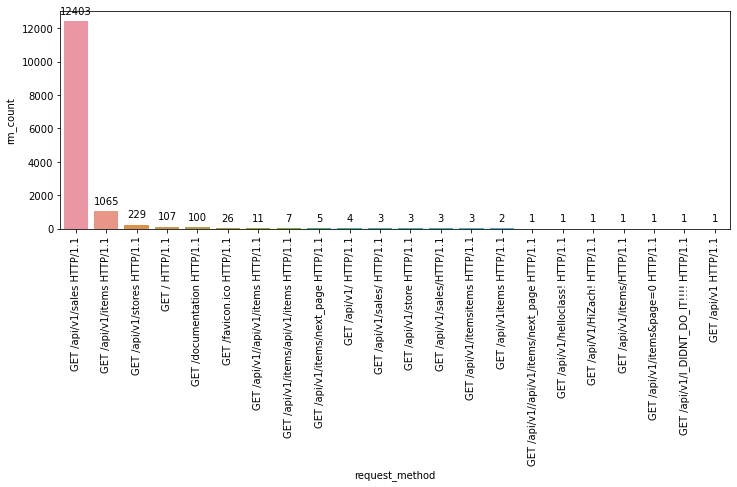

In [21]:
# plot the rm_count for each request_method

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=rm_df, x = 'request_method', y = 'rm_count')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

### Detecting anomalies by establishing a baseline and evaluate as new data arrives.


#### Establish Baseline:

In [22]:
df.index.min(), df.index.max()

(Timestamp('2019-04-16 19:34:42'), Timestamp('2019-04-21 10:02:41'))

In [23]:
df.tail(25)

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-17 12:54:55,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.487761
2019-04-17 12:54:57,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488843
2019-04-17 12:54:58,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.487440
2019-04-17 12:54:59,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.487878
2019-04-17 12:54:59,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486393
2019-04-17 12:55:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.487833
2019-04-17 12:55:01,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.489937
2019-04-17 12:55:03,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486488
2019-04-17 12:55:03,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488242


In [24]:
# #establish baseline 

train = df

In [25]:
# Compute probabilities based on train sample:

rm_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index()

rm_df.head()

,index,request_method
0,GET /api/v1/sales HTTP/1.1,0.887323
1,GET /api/v1/items HTTP/1.1,0.076191
2,GET /api/v1/stores HTTP/1.1,0.016383
3,GET / HTTP/1.1,0.007655
4,GET /documentation HTTP/1.1,0.007154


In [26]:
rm_df.rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_proba'})

,request_method,rm_proba
0,GET /api/v1/sales HTTP/1.1,0.887323
1,GET /api/v1/items HTTP/1.1,0.076191
2,GET /api/v1/stores HTTP/1.1,0.016383
3,GET / HTTP/1.1,0.007655
4,GET /documentation HTTP/1.1,0.007154
5,GET /favicon.ico HTTP/1.1,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,0.000358
9,GET /api/v1/ HTTP/1.1,0.000286


In [ ]:
Takeaways: 
* anamolies:
    * GET / HTTP/1.1 ... no references
    * GET /api/v1//api/v1/items HTTP/1.1  ... double references & double '//'
    * GET /api/v1/items/api/v1/items HTTP/1.1 ... duplicate references
    * GET /api/v1/ HTTP/1.1  ... missing value following v1/
    * GET /api/v1/sales/ HTTP/1.1 ... no need for '/' after sales
    * GET /api/v1/store HTTP/1.1 ... store should be plural
    * GET /api/v1/sales/HTTP/1.1  ... sales'/'hTTP should be space 
    * GET /api/v1/itemsitems HTTP/1.1 ... dupliated 'items'
    * GET /api/v1items HTTP/1.1 ... missing '/' delimiter
    * GET /api/v1//api/v1/items/next_page HTTP/1.1	.. repeated commands
    * GET /api/v1/items/HTTP/1.1 ... extra '/'
    * https://www.goodhousekeeping.com/life/news/a33058/hanging-baby-cages/
    * GET /api/v1/items&page=0 HTTP/1.1  ... page 0
    * GET /api/v1 HTTP/1.1 missing df reference (i.e. stores/sales/etc.)
* low_occurences:
    * GET /documentation HTTP/1.1
    * GET /favicon.ico HTTP/1.1
    * GET /api/v1/helloclass! HTTP/1.1
    * GET /api/V1/HiZach! HTTP/1.1
    * GET /api/v1/items/next_page HTTP/1.1
    * GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1